In [51]:
import pandas as pd
from pandas.plotting import register_matplotlib_converters

datasets = ['datasets/drought.csv', 'datasets/diabetic_data.csv']
dict_path = {'Set1':datasets[1], 'Set2':datasets[0]}
dict_name = {'Set1':'diabetic', 'Set2':'climate'}


## SET 1 - DIABETIC DATA

### Dummification

In [52]:
file_path = dict_path['Set1']
file_name = dict_name['Set1']
data = pd.read_csv(file_path, na_values='?')


In [53]:
#variable dummification

from pandas import DataFrame, concat
from ds_charts import get_variable_types
from sklearn.preprocessing import OneHotEncoder
from numpy import number

#drop out all records with missing values
data.dropna(inplace=True)

def dummify(df, vars_to_dummify):
    other_vars = [c for c in df.columns if not c in vars_to_dummify]
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=bool)
    X = df[vars_to_dummify]
    encoder.fit(X)
    new_vars = encoder.get_feature_names(vars_to_dummify)
    trans_X = encoder.transform(X)
    dummy = DataFrame(trans_X, columns=new_vars, index=X.index)
    dummy = dummy.convert_dtypes(convert_boolean=True)

    final_df = concat([df[other_vars], dummy], axis=1)
    return final_df

variables = get_variable_types(data)
symbolic_vars = variables['Symbolic']
binary_vars = variables['Binary'] #only have symbolic ones
numeric_vars = variables['Numeric']
date_vars = variables['Date']
print('num:', len(numeric_vars))
print('symb:', len(symbolic_vars))
print('bin:', len(binary_vars))
print('date:', len(date_vars))
print('toal:', len(data.columns))

variables_to_dummify = symbolic_vars+binary_vars

df = dummify(data, variables_to_dummify)
name = file_path+'_dummified.csv'
df.to_csv(name, index=False)

df.describe(include=[bool])

num: 13
symb: 31
bin: 6
date: 0
toal: 50


,race_AfricanAmerican,race_Asian,race_Caucasian,race_Other,age_[0-10),age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60),...,nateglinide_No,nateglinide_Steady,rosiglitazone_No,rosiglitazone_Steady,acarbose_No,acarbose_Steady,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
count,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043,...,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,True,False,False,False,False,False,False,False,...,True,False,True,False,True,False,False,True,False,True
freq,1011,1042,997,1030,1042,1042,1025,1018,975,866,...,1035,1035,982,982,1036,1036,746,746,667,667


### Missing values imputation

total: 50


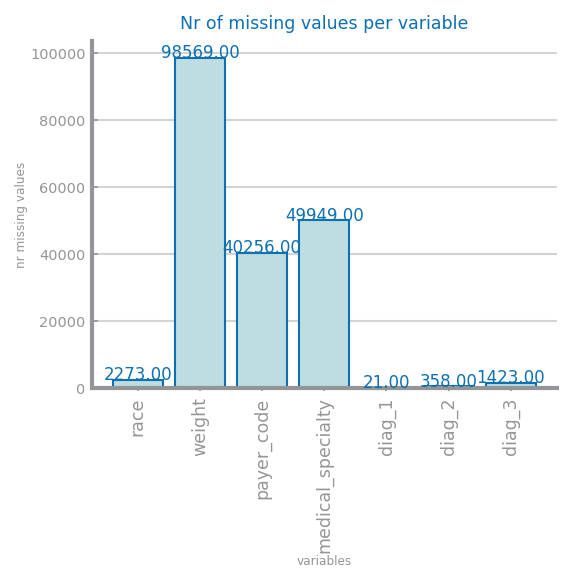

In [54]:
#missing values imputation

from matplotlib.pyplot import figure, savefig
from ds_charts import bar_chart

data = pd.read_csv(file_path, na_values='?')

mv = {}
figure()
count = 0
for var in data:
    count += 1
    nr = data[var].isna().sum()
    if nr > 0:
        mv[var] = nr

print('total:', count)
bar_chart(list(mv.keys()), list(mv.values()), title='Nr of missing values per variable', xlabel='variables', ylabel='nr missing values', rotation=True)

In [55]:
#dropping missing values

# defines the number of records to discard entire columns
threshold = data.shape[0] * 0.75
missings = [c for c in mv.keys() if mv[c]>threshold]
data_dropped = data.drop(columns=missings, inplace=False)
#df.to_csv(f'data/{file}_drop_columns_mv.csv', index=True)
print('Dropped variables', missings)

# defines the number of variables to discard entire records
#it discards rows that have more than 95% missing values
threshold = data.shape[1] * 0.95 
df = data.dropna(thresh=threshold, inplace=False)
#df.to_csv(f'data/{file}_drop_records_mv.csv', index=True)
print(df.shape)

Dropped variables ['weight']
(83534, 50)


In [56]:
#filling missing values

data = pd.read_csv(file_path, na_values='?')

#strategy to fill missing values: constant, mean, median, most_frequent

from sklearn.impute import SimpleImputer
from pandas import concat, DataFrame
from ds_charts import get_variable_types
from numpy import nan

tmp_nr, tmp_sb, tmp_bool = None, None, None
variables = get_variable_types(data)
numeric_vars = variables['Numeric']
symbolic_vars = variables['Symbolic']
binary_vars = variables['Binary']

if len(numeric_vars) > 0:
    imp = SimpleImputer(strategy='constant', fill_value=0, missing_values=nan, copy=True)
    tmp_nr = DataFrame(imp.fit_transform(data[numeric_vars]), columns=numeric_vars)
if len(symbolic_vars) > 0:
    imp = SimpleImputer(strategy='constant', fill_value='NA', missing_values=nan, copy=True)
    tmp_sb = DataFrame(imp.fit_transform(data[symbolic_vars]), columns=symbolic_vars)
if len(binary_vars) > 0:
    imp = SimpleImputer(strategy='constant', fill_value=False, missing_values=nan, copy=True)
    tmp_bool = DataFrame(imp.fit_transform(data[binary_vars]), columns=binary_vars)

df = concat([tmp_nr, tmp_sb, tmp_bool], axis=1)
df.index = data.index
#df.to_csv(f'data/{file}_mv_constant.csv', index=True)
df.describe(include='all')

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,readmitted,acetohexamide,tolbutamide,troglitazone,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,2,2,2,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NO,No,No,No,No,No,No,No,No,Yes
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,54864,101765,101743,101763,101753,101765,101764,101765,54755,78363
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
#filling missng values

data = pd.read_csv(file_path, na_values='?')

#strategy to fill missing values: constant, mean, median, most_frequent

from sklearn.impute import SimpleImputer
from pandas import concat, DataFrame
from ds_charts import get_variable_types
from numpy import nan

tmp_nr, tmp_sb, tmp_bool = None, None, None
variables = get_variable_types(data)
numeric_vars = variables['Numeric']
symbolic_vars = variables['Symbolic']
binary_vars = variables['Binary']

if len(numeric_vars) > 0:
    imp_mean = SimpleImputer(strategy='mean', missing_values=nan, copy=True)
    tmp_nr_mean = DataFrame(imp.fit_transform(data[numeric_vars]), columns=numeric_vars)
    imp_median = SimpleImputer(strategy='median', missing_values=nan, copy=True)
    tmp_nr_median = DataFrame(imp.fit_transform(data[numeric_vars]), columns=numeric_vars)
if len(symbolic_vars) > 0:
    imp = SimpleImputer(strategy='most_frequent', missing_values=nan, copy=True)
    tmp_sb = DataFrame(imp.fit_transform(data[symbolic_vars]), columns=symbolic_vars)
if len(binary_vars) > 0:
    imp = SimpleImputer(strategy='most_frequent', missing_values=nan, copy=True)
    tmp_bool = DataFrame(imp.fit_transform(data[binary_vars]), columns=binary_vars)

df_mean = concat([tmp_nr_mean, tmp_sb, tmp_bool], axis=1)
df_mean.index = data.index
df_mean.to_csv(f'datasets/{file_name}_mv_mean.csv', index=True)

df_median = concat([tmp_nr_median, tmp_sb, tmp_bool], axis=1)
df_median.index = data.index
df_median.to_csv(f'datasets/{file_name}_mv_median.csv', index=True)
df.describe(include='all')

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,readmitted,acetohexamide,tolbutamide,troglitazone,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,2,2,2,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NO,No,No,No,No,No,No,No,No,Yes
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,54864,101765,101743,101763,101753,101765,101764,101765,54755,78363
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Dealing with outliers

In [64]:
#dropping outliers

data = pd.read_csv(file_path, na_values='?')

from pandas import DataFrame
from ds_charts import get_variable_types

OUTLIER_PARAM: int = 2 # define the number of stdev to use or the IQR scale (usually 1.5)
OPTION = 'stdev'  # or 'stdev'

def determine_outlier_thresholds(summary5: DataFrame, var: str):
    if 'iqr' == OPTION:
        iqr = OUTLIER_PARAM * (summary5[var]['75%'] - summary5[var]['25%'])
        top_threshold = summary5[var]['75%']  + iqr
        bottom_threshold = summary5[var]['25%']  - iqr
    else:  # OPTION == 'stdev'
        std = OUTLIER_PARAM * summary5[var]['std']
        top_threshold = summary5[var]['mean'] + std
        bottom_threshold = summary5[var]['mean'] - std
    return top_threshold, bottom_threshold

numeric_vars = get_variable_types(data)['Numeric']
if [] == numeric_vars:
    raise ValueError('There are no numeric variables.')
print('Original data:', data.shape)


summary5 = data.describe(include='number')
df = data.copy(deep=True)
for var in numeric_vars:
    top_threshold, bottom_threshold = determine_outlier_thresholds(summary5, var)
    outliers = df[(df[var] > top_threshold) | (df[var] < bottom_threshold)]
    df.drop(outliers.index, axis=0, inplace=True)
df.to_csv(f'datasets/{file_name}_drop_outliers.csv', index=True)
print('data after dropping outliers:', df.shape)

Original data: (101766, 50)
data after dropping outliers: (54387, 50)


In [76]:
#replacing outliers with fixed value
#median

if [] == numeric_vars:
    raise ValueError('There are no numeric variables.')

summary5 = data.describe(include='number')
df = data.copy(deep=True)
for var in numeric_vars:
    top_threshold, bottom_threshold = determine_outlier_thresholds(summary5, var)
    median = df[var].median()
    df[var] = df[var].apply(lambda x: median if x > top_threshold or x < bottom_threshold else x)

#print('data after replacing outliers:', df.describe())
df.to_csv(f'datasets/{file_name}_replacing_outliers.csv', index=True)

In [75]:
#truncating outliers

if [] == numeric_vars:
    raise ValueError('There are no numeric variables.')

summary5 = data.describe(include='number')
df = data.copy(deep=True)
for var in numeric_vars:
    top_threshold, bottom_threshold = determine_outlier_thresholds(summary5, var)
    df[var] = df[var].apply(lambda x: top_threshold if x > top_threshold else bottom_threshold if x < bottom_threshold else x)

#print('data after truncating outliers:', df.describe())
df.to_csv(f'datasets/{file_name}_truncate_outliers.csv', index=True)

### Scaling

In [80]:
data = pd.read_csv(file_path, na_values='?')

from ds_charts import get_variable_types

variable_types = get_variable_types(data)
numeric_vars = variable_types['Numeric']
symbolic_vars = variable_types['Symbolic']
boolean_vars = variable_types['Binary']

df_nr = data[numeric_vars]
df_sb = data[symbolic_vars]
df_bool = data[boolean_vars]


In [83]:
#standard scaler
from sklearn.preprocessing import StandardScaler
from pandas import DataFrame, concat

transf = StandardScaler(with_mean=True, with_std=True, copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=data.index, columns= numeric_vars)
norm_data_zscore = concat([tmp, df_sb,  df_bool], axis=1)
norm_data_zscore.to_csv(f'datasets/{file_name}_scaled_zscore.csv', index=False)

In [85]:
#minMax scaler
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame, concat

transf = MinMaxScaler(feature_range=(0, 1), copy=True).fit(df_nr)
tmp = DataFrame(transf.transform(df_nr), index=data.index, columns= numeric_vars)
norm_data_minmax = concat([tmp, df_sb,  df_bool], axis=1)
norm_data_minmax.to_csv(f'datasets/{file_name}_scaled_minmax.csv', index=False)
#print(norm_data_minmax.describe())

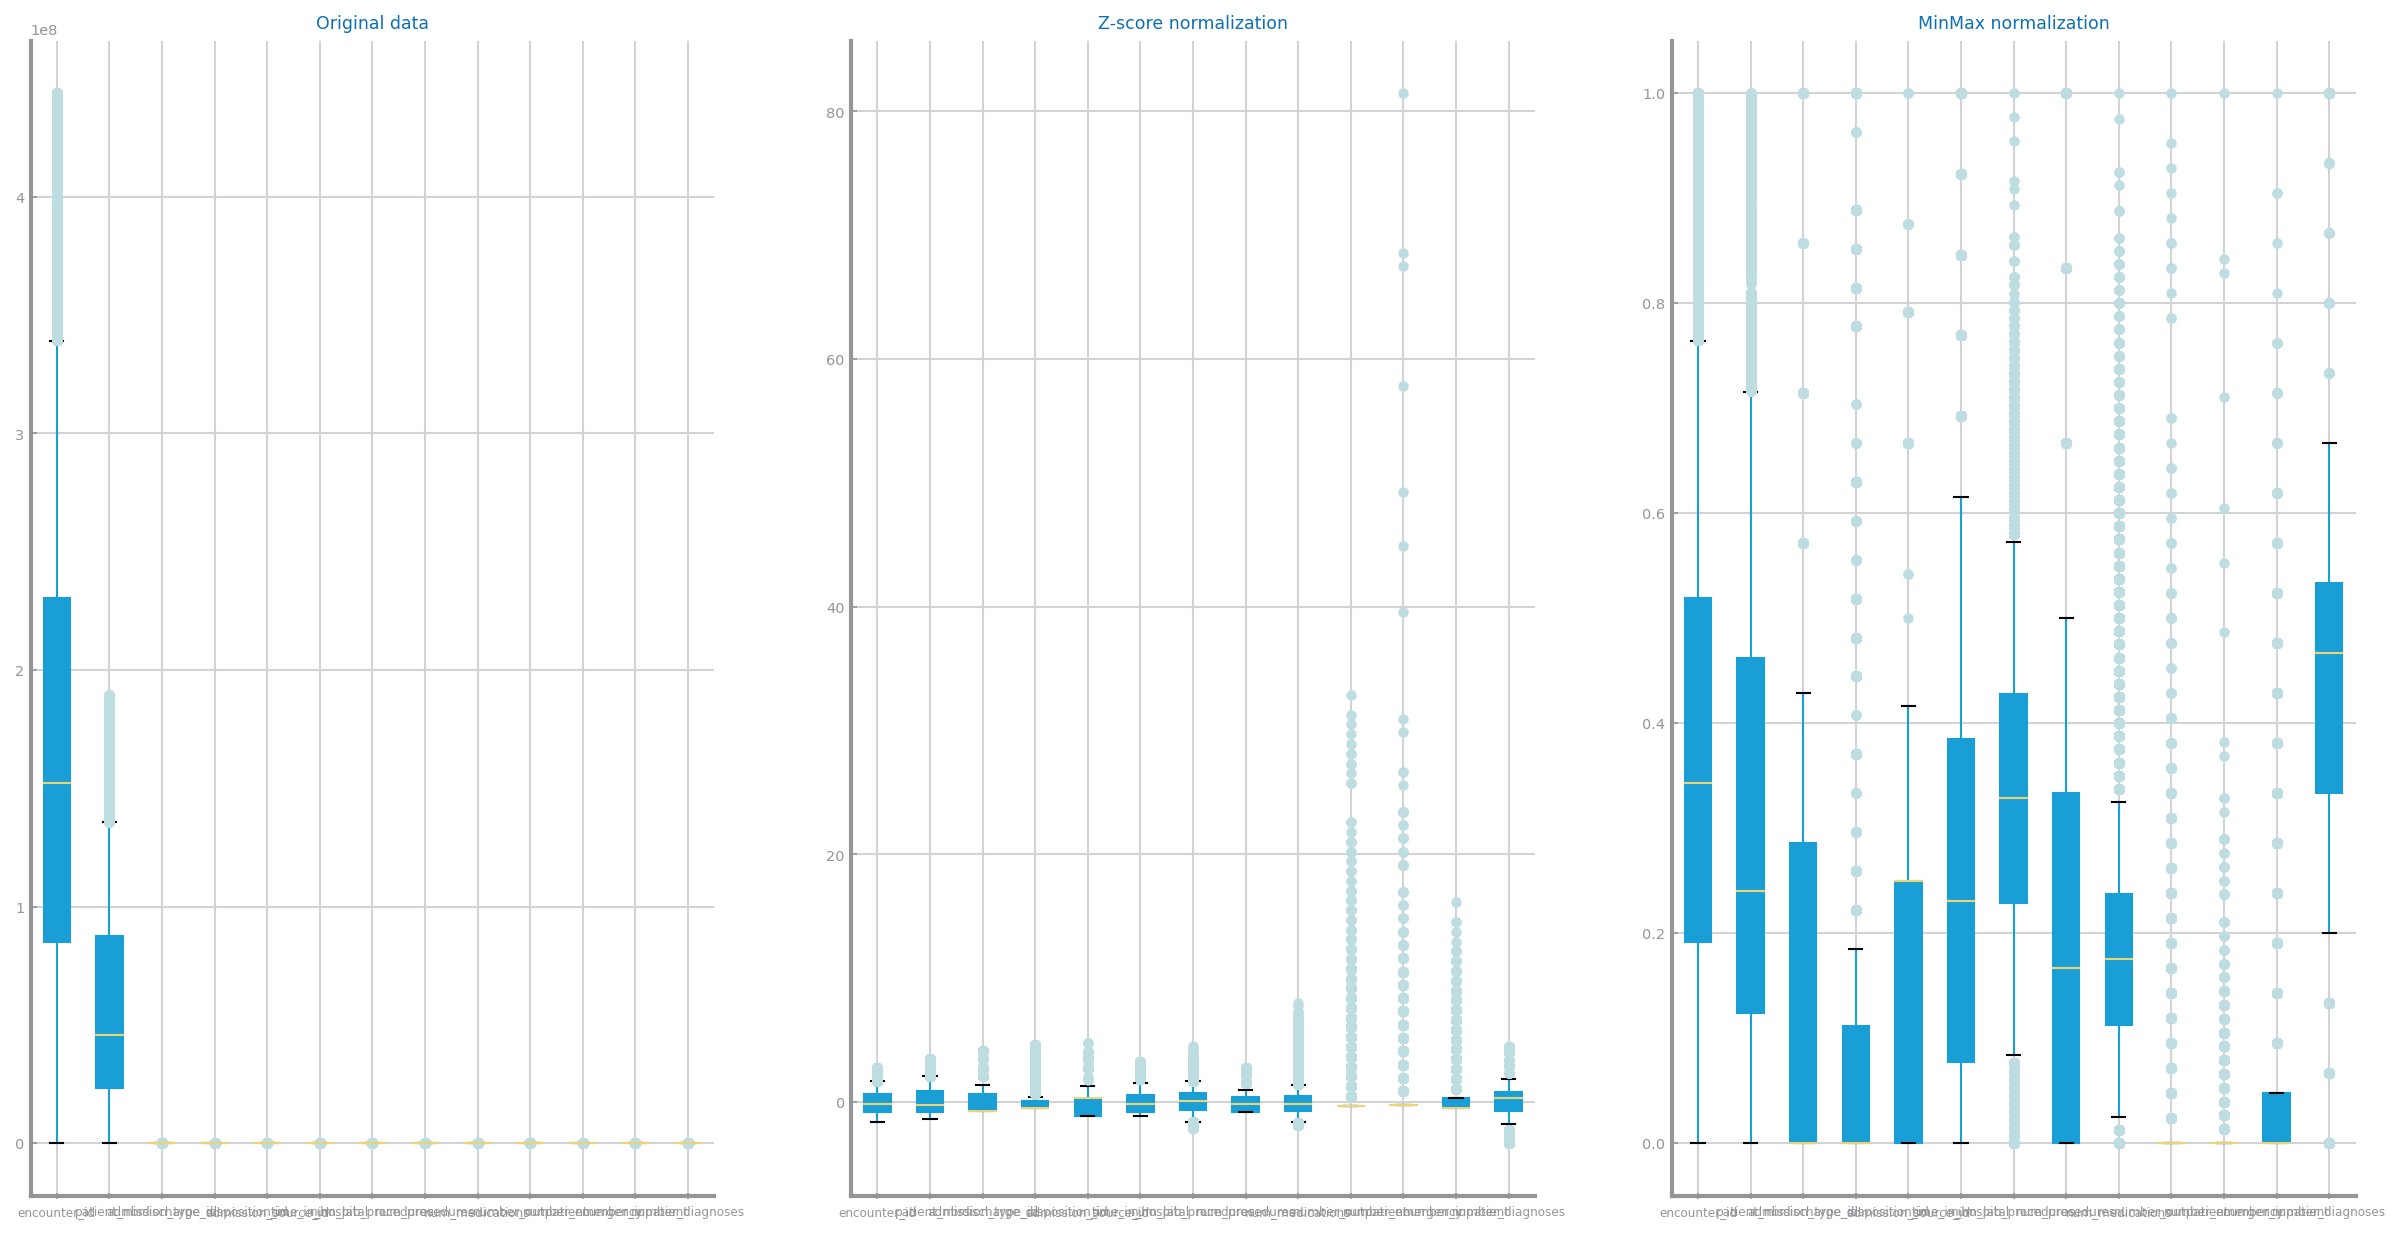

In [86]:
from matplotlib.pyplot import subplots, show

fig, axs = subplots(1, 3, figsize=(20,10),squeeze=False)
axs[0, 0].set_title('Original data')
data.boxplot(ax=axs[0, 0])
axs[0, 1].set_title('Z-score normalization')
norm_data_zscore.boxplot(ax=axs[0, 1])
axs[0, 2].set_title('MinMax normalization')
norm_data_minmax.boxplot(ax=axs[0, 2])
show()

### Data balancing

Minority class= <30 : 11357
Majority class= NO : 54864
Proportion: 0.21 : 1


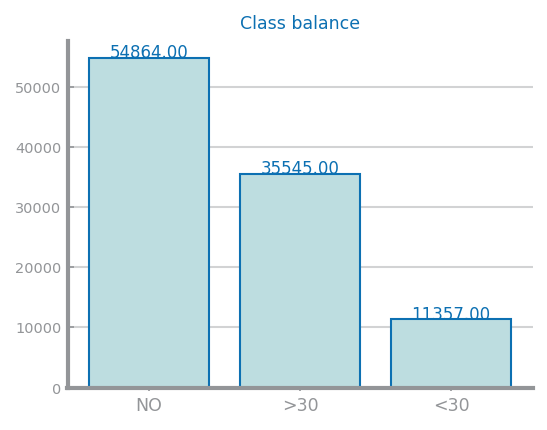

In [126]:
from pandas import read_csv
from matplotlib.pyplot import figure, savefig, show
from ds_charts import bar_chart

filename = file_path
original = read_csv(filename, sep=',', decimal='.')
class_var = 'readmitted'

target_count = original[class_var].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()
#ind_positive_class = target_count.index.get_loc(positive_class)
print('Minority class=', positive_class, ':', target_count[positive_class])
print('Majority class=', negative_class, ':', target_count[negative_class])
print('Proportion:', round(target_count[positive_class] / target_count[negative_class], 2), ': 1')
values = {'Original': [target_count[positive_class], target_count[negative_class]]}

figure()
bar_chart(target_count.index, target_count.values, title='Class balance')
#savefig(f'images/{file}_balance.png')
show()

In [127]:
#split the dataset, one for each class

df_no = original[original[class_var] == 'NO']
df_more_than_30 = original[original[class_var] == '>30']
df_less_than_30 = original[original[class_var] == '<30']

df_positives = original[original[class_var] == positive_class]
df_negatives = original[original[class_var] == negative_class]

In [128]:
#undersampling

from pandas import concat, DataFrame

df_neg_sample = DataFrame(df_negatives.sample(len(df_positives)))
df_under = concat([df_positives, df_neg_sample], axis=0)
#df_under.to_csv(f'data/{file}_under.csv', index=False)
values['UnderSample'] = [len(df_positives), len(df_neg_sample)]
print('Minority class=', positive_class, ':', len(df_positives))
print('Majority class=', negative_class, ':', len(df_neg_sample))
print('Proportion:', round(len(df_positives) / len(df_neg_sample), 2), ': 1')

Minority class= <30 : 11357
Majority class= NO : 11357
Proportion: 1.0 : 1


In [129]:
#oversampling

from pandas import concat, DataFrame

df_pos_sample = DataFrame(df_positives.sample(len(df_negatives), replace=True))
df_over = concat([df_pos_sample, df_negatives], axis=0)
#df_over.to_csv(f'data/{file}_over.csv', index=False)
values['OverSample'] = [len(df_pos_sample), len(df_negatives)]

print('Minority class=', positive_class, ':', len(df_pos_sample))
print('Majority class=', negative_class, ':', len(df_negatives))
print('Proportion:', round(len(df_pos_sample) / len(df_negatives), 2), ': 1')

Minority class= <30 : 54864
Majority class= NO : 54864
Proportion: 1.0 : 1


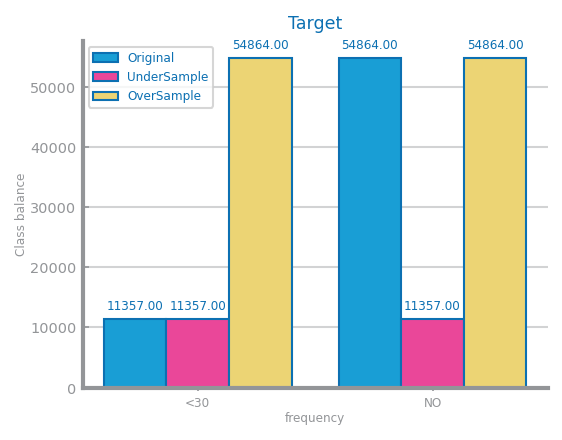

In [130]:
from matplotlib.pyplot import figure, show
from ds_charts import multiple_bar_chart

figure()
multiple_bar_chart([positive_class, negative_class], values, title='Target', xlabel='frequency', ylabel='Class balance')
show()

### Discretization

In [133]:
from ds_charts import get_variable_types

data = pd.read_csv(file_path, na_values='?')

variable_types = get_variable_types(data)
numeric_vars = variable_types['Numeric']
symbolic_vars = variable_types['Symbolic']
boolean_vars = variable_types['Binary']

df_nr = data[numeric_vars]
df_sb = data[symbolic_vars]
df_bool = data[boolean_vars]

array([[<AxesSubplot:title={'center':'encounter_id'}>,
        <AxesSubplot:title={'center':'patient_nbr'}>,
        <AxesSubplot:title={'center':'admission_type_id'}>,
        <AxesSubplot:title={'center':'discharge_disposition_id'}>],
       [<AxesSubplot:title={'center':'admission_source_id'}>,
        <AxesSubplot:title={'center':'time_in_hospital'}>,
        <AxesSubplot:title={'center':'num_lab_procedures'}>,
        <AxesSubplot:title={'center':'num_procedures'}>],
       [<AxesSubplot:title={'center':'num_medications'}>,
        <AxesSubplot:title={'center':'number_outpatient'}>,
        <AxesSubplot:title={'center':'number_emergency'}>,
        <AxesSubplot:title={'center':'number_inpatient'}>],
       [<AxesSubplot:title={'center':'number_diagnoses'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

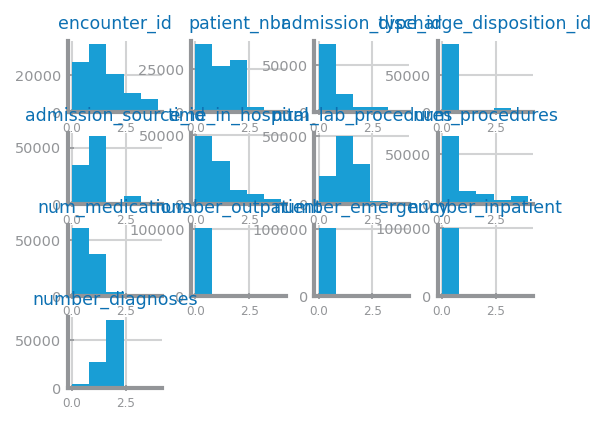

In [137]:
#equal-width

from sklearn.preprocessing import KBinsDiscretizer
from pandas import DataFrame, concat

N_BINS = 5
discretization = KBinsDiscretizer(n_bins=N_BINS, encode="ordinal", strategy="uniform")
discretization.fit(df_nr)
eq_width = DataFrame(discretization.transform(df_nr), index=data.index)

df = DataFrame(df_sb, index=data.index)
df = concat([df, df_bool, eq_width], axis=1)
df.columns = symbolic_vars + boolean_vars + numeric_vars
#df.to_csv(f'data/{file}_eq_width.csv', index=True)

df.hist(bins=N_BINS)

array([[<AxesSubplot:title={'center':'encounter_id'}>,
        <AxesSubplot:title={'center':'patient_nbr'}>,
        <AxesSubplot:title={'center':'admission_type_id'}>,
        <AxesSubplot:title={'center':'discharge_disposition_id'}>],
       [<AxesSubplot:title={'center':'admission_source_id'}>,
        <AxesSubplot:title={'center':'time_in_hospital'}>,
        <AxesSubplot:title={'center':'num_lab_procedures'}>,
        <AxesSubplot:title={'center':'num_procedures'}>],
       [<AxesSubplot:title={'center':'num_medications'}>,
        <AxesSubplot:title={'center':'number_outpatient'}>,
        <AxesSubplot:title={'center':'number_emergency'}>,
        <AxesSubplot:title={'center':'number_inpatient'}>],
       [<AxesSubplot:title={'center':'number_diagnoses'}>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

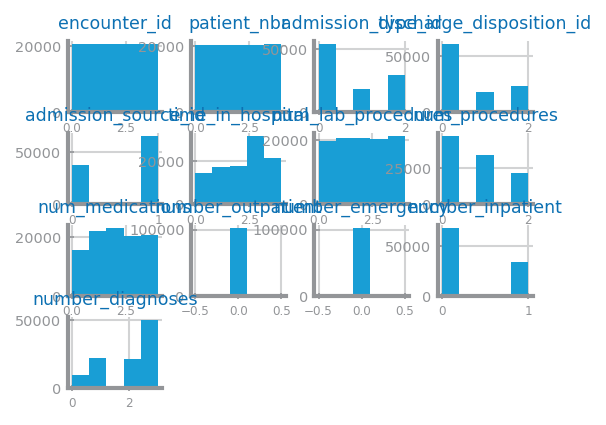

In [139]:
#equal-frequency 

discretization = KBinsDiscretizer(n_bins=N_BINS, encode="ordinal", strategy="quantile")
discretization.fit(df_nr)
eq_width = DataFrame(discretization.transform(df_nr), index=data.index)

df = DataFrame(df_sb, index=data.index)
df = concat([df, df_bool, eq_width], axis=1)
df.columns = symbolic_vars + boolean_vars + numeric_vars
#df.to_csv(f'data/{file}_eq_frequency.csv', index=True)

df.hist(bins=N_BINS)